# Mecanismo de deteccion de anomalias

A continuacion se presenta la generacion del modelo de deteccion de anomalias que se propone en la presente investigacion

In [1]:
import numpy as np
import pandas as pd

## 1. Cargar y etiquetar el conjunto de entrenamiento

In [2]:
def load(path):
    df = pd.read_csv(path, header=0)
    return df[["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"]]

In [3]:
path = "Final/datos_movimiento.csv"
datos_total = load(path)

In [4]:
# Anomalias
anomaly = np.zeros(len(datos_total))

anomaly[22865:22892]=1 # zig zag
anomaly[22903:22926]= 0 # tierra
anomaly[22966:22990]=1 # zig zag
anomaly[23015:23027]=1 # zig zag
anomaly[23158:23183]= 0 # tierra
anomaly[23212:23236]=1 # zig zag 
anomaly[23256:23274]=1 # zig zag

anomaly[23556:23562]=1 # giros a alta velocidad
anomaly[23590:23596]=1
anomaly[23606:23612]=1
anomaly[23615:23621]=1
anomaly[23760:23766]=1
anomaly[23774:23779]=1
anomaly[24794:24798]=1

anomaly[23933:24939]=0 # anomalias raras
anomaly[25076:25086]=0

anomaly[25502:25506]=1 # frenos en seco
anomaly[25575:25579]=1
anomaly[25623:25627]=1
anomaly[25710:25714]=1
anomaly[25838:25842]=1
anomaly[25871:25875]=1

datos_total['anomaly'] = anomaly

In [5]:
import os
import tensorflow as tf
#from tensorflow.keras import backend as K
from keras import backend as K
import random as rn
rand_seed = 321
os.environ['PYTHONHASHSEED'] = '0'

#import tensorflow.compat.v1 as tf
import tensorflow as tf
#tf.disable_v2_behavior()
tf.get_default_graph
#random seed for NP genreator of ranodm numbers
np.random.seed(rand_seed)

#random seed generator for Python
rn.seed(rand_seed)

#random seed for tensorflow
tf.set_random_seed(rand_seed)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [6]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import matplotlib.transforms as mtransforms

In [7]:
def dibujar_sensores(df):
    fig, ax = plt.subplots()
    indices = list(range(0,len(df)))
    
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

    ax.plot(indices, df['acc_x'], 'r', label='ACC-X')
    ax.plot(indices, df['acc_y'], 'b', label='ACC-Y')
    ax.plot(indices, df['acc_z'], 'g', label='ACC-Z')
    ax.plot(indices, df['gyr_x'], 'm', label='GYR-X')
    ax.plot(indices, df['gyr_y'], 'c', label='GYR-Y')
    ax.plot(indices, df['gyr_z'], 'k', label='GYR-Z')

    ax.set(ylabel='Valores sensores', xlabel='Tiempo (Segundos)', title='Datos capturados - Horizontal')
    ax.legend()
    plt.xlabel('Datos')
    plt.savefig('horizontal.png')
    plt.show() 

In [8]:
data3 = pd.concat([datos_total[:17224], datos_total[17290:17661], datos_total[28400:]])[:30000] 

In [9]:
d = pd.concat([datos_total[:17224], datos_total[17290:17661], datos_total[28400:]])[30000:]
data_test = pd.concat([d,datos_total[17224:17290], datos_total[17661:28400]])

<IPython.core.display.Javascript object>


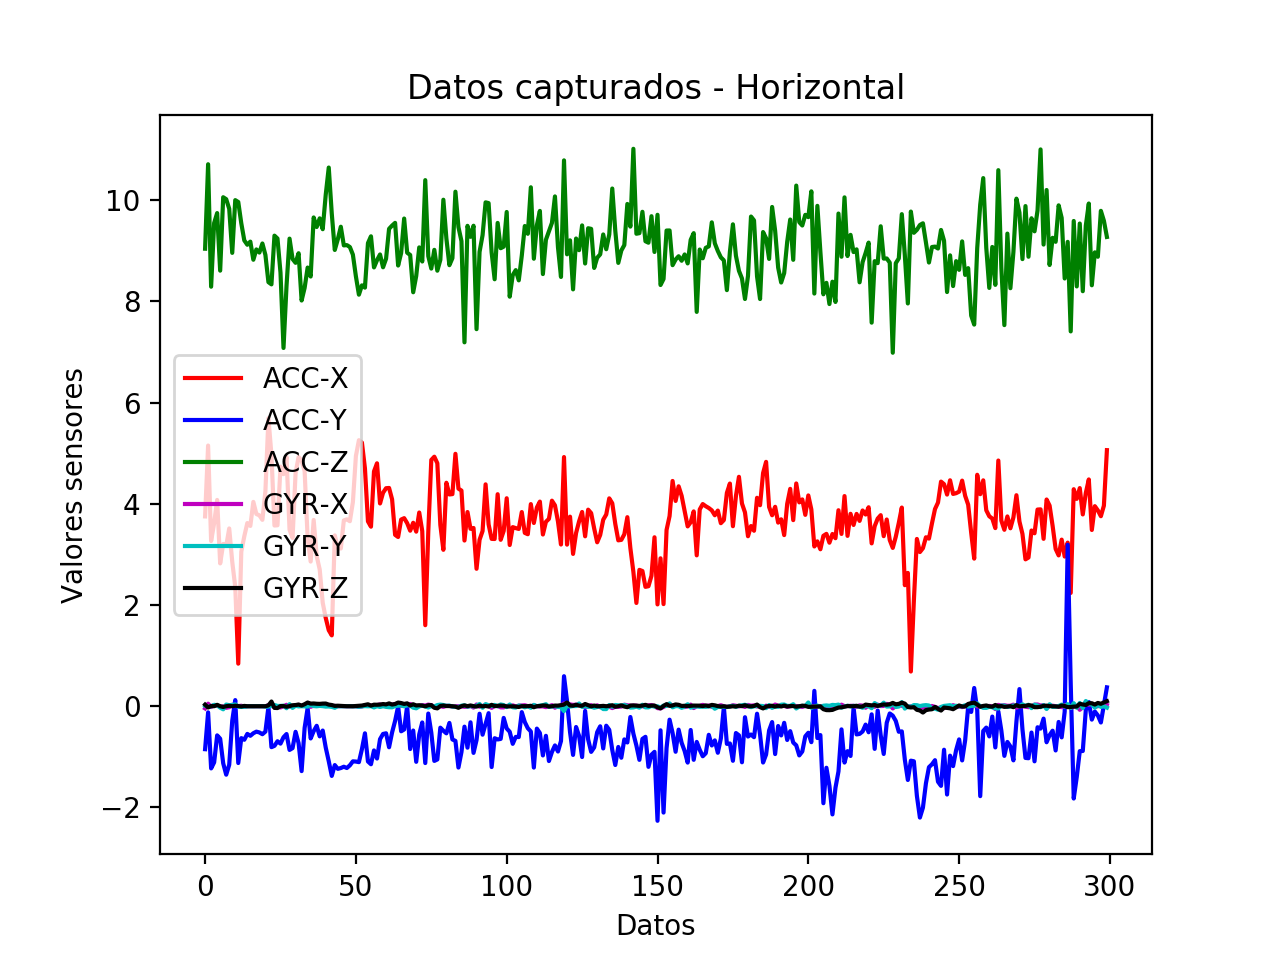

In [10]:
dibujar_sensores(data3[4000:4300])

## 2. Eliminacion de ruido

Aplicacion de la regla 67-95-99

In [11]:
def delete_outliers(data_column, limit):
    elements = np.array(data_column)
    mean = np.mean(elements, axis=0)
    sd = np.std(elements, axis=0)
    final_list = [x for x in elements if (x > mean - limit * sd)]
    final_list = [x for x in final_list if (x < mean + limit * sd)]
    return np.array(final_list)

In [12]:
from sklearn import preprocessing

i = 3
val_1 = delete_outliers(data3["acc_x"], i)
val_2 = delete_outliers(data3["acc_y"], i)
val_3 = delete_outliers(data3["acc_z"], i)
val_4 = delete_outliers(data3["gyr_x"], i)
val_5 = delete_outliers(data3["gyr_y"], i)
val_6 = delete_outliers(data3["gyr_z"], i)

max_val = min([len(val_1),len(val_2),len(val_3),len(val_4),len(val_5),len(val_6)])

a = np.concatenate((val_1[:max_val].reshape(max_val,1), val_2[:max_val].reshape(max_val,1), val_3[:max_val].reshape(max_val,1), val_4[:max_val].reshape(max_val,1), val_5[:max_val].reshape(max_val,1), val_6[:max_val].reshape(max_val,1)), axis=1)

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
#from tensorflow.keras.layers import Input, Dense,  Flatten, Reshape
from keras.layers import Input, Dense,  Flatten, Reshape
#from tensorflow.keras.models import Model
from keras.models import Model

## 3. Normalizacion de datos

Aplicar la normalizacion Min-Max a los datos

In [14]:
scaler = MinMaxScaler()
scaler.fit(a)
x = scaler.transform(data3[["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"]])
total = scaler.transform(datos_total[["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"]][:-20])

In [15]:
x = pd.DataFrame({'acc_x': x[:,0], 'acc_y': x[:,1], 'acc_z': x[:,2], 'gyr_x': x[:,3], 'gyr_y': x[:,4], 'gyr_z': x[:,5]})

In [16]:
test = scaler.transform(data_test[["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"]][:-20])
test = pd.DataFrame({'acc_x': test[:,0], 'acc_y': test[:,1], 'acc_z': test[:,2], 'gyr_x': test[:,3], 'gyr_y': test[:,4], 'gyr_z': test[:,5]})

In [17]:
y = x.loc[((x.acc_x <= 1) & (x.acc_x >= 0)) &((x.acc_y <= 1) & (x.acc_y >=0))& ((x.acc_z <= 1) & (x.acc_z >=0)) &((x.gyr_x <= 1) & (x.gyr_x >=0))&((x.gyr_y <= 1) & (x.gyr_y >=0)) &((x.gyr_z <= 1) & (x.gyr_z >=0)) ]
y.shape

(28719, 6)

## 4. Reduccion de datos

Aplicacion de PCA para pasar de 6 variables a 3

[0.51035188 0.20696465 0.13414971 0.07489895 0.05038002 0.02325478]


<IPython.core.display.Javascript object>


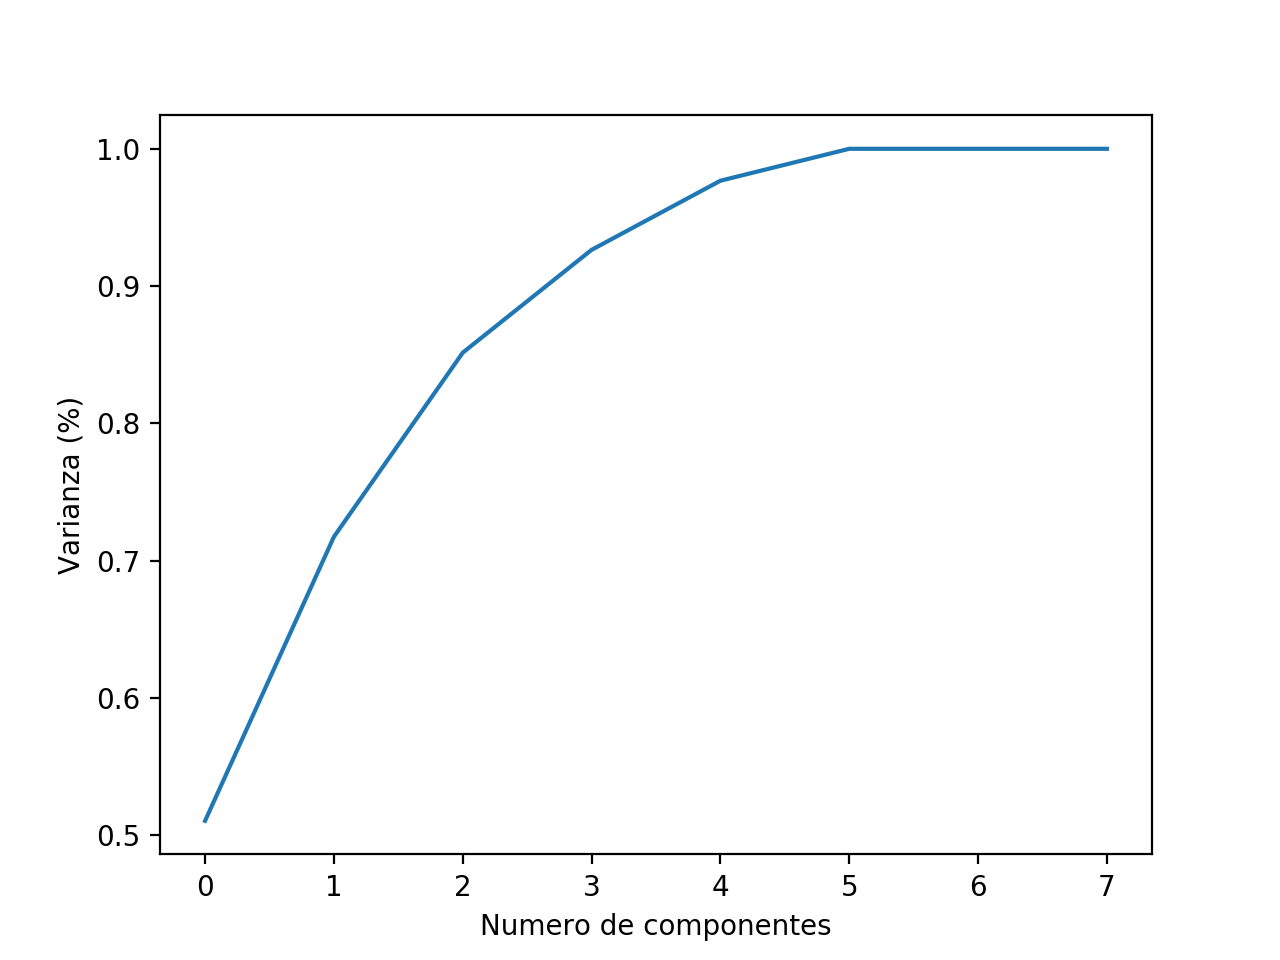

In [18]:
from sklearn.decomposition import PCA
#Fitting the PCA algorithm with our Data
pca = PCA().fit(y)

print(pca.explained_variance_ratio_)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(np. concatenate((pca.explained_variance_ratio_, [0,0]))))
plt.xlabel('Numero de componentes')
plt.ylabel('Varianza (%)') #for each component
plt.savefig("pca.png")
plt.show()

In [19]:
pca3 = PCA(n_components=3)
pca3.fit(y)
principalComponents3 = pca3.transform(x)
principalComponentsTotal3 = pca3.transform(total)

In [20]:
principalComponentsTest = pca3.transform(test)

In [21]:
def dibujar_sensores_pca(df):
    fig, ax = plt.subplots()
    indices = list(range(0,len(df)))
    
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

    ax.plot(indices, df[:,0], 'r', label='C_1')
    ax.plot(indices, df[:,1], 'b', label='C_2')
    ax.plot(indices, df[:,2], 'g', label='C_3')

    ax.set(ylabel='Valores sensores', xlabel='Tiempo (Segundos)', title='Datos capturados - Horizontal')
    ax.legend()
    plt.xlabel('Datos')
    plt.savefig('horizontal.png')
    plt.show() 

<IPython.core.display.Javascript object>


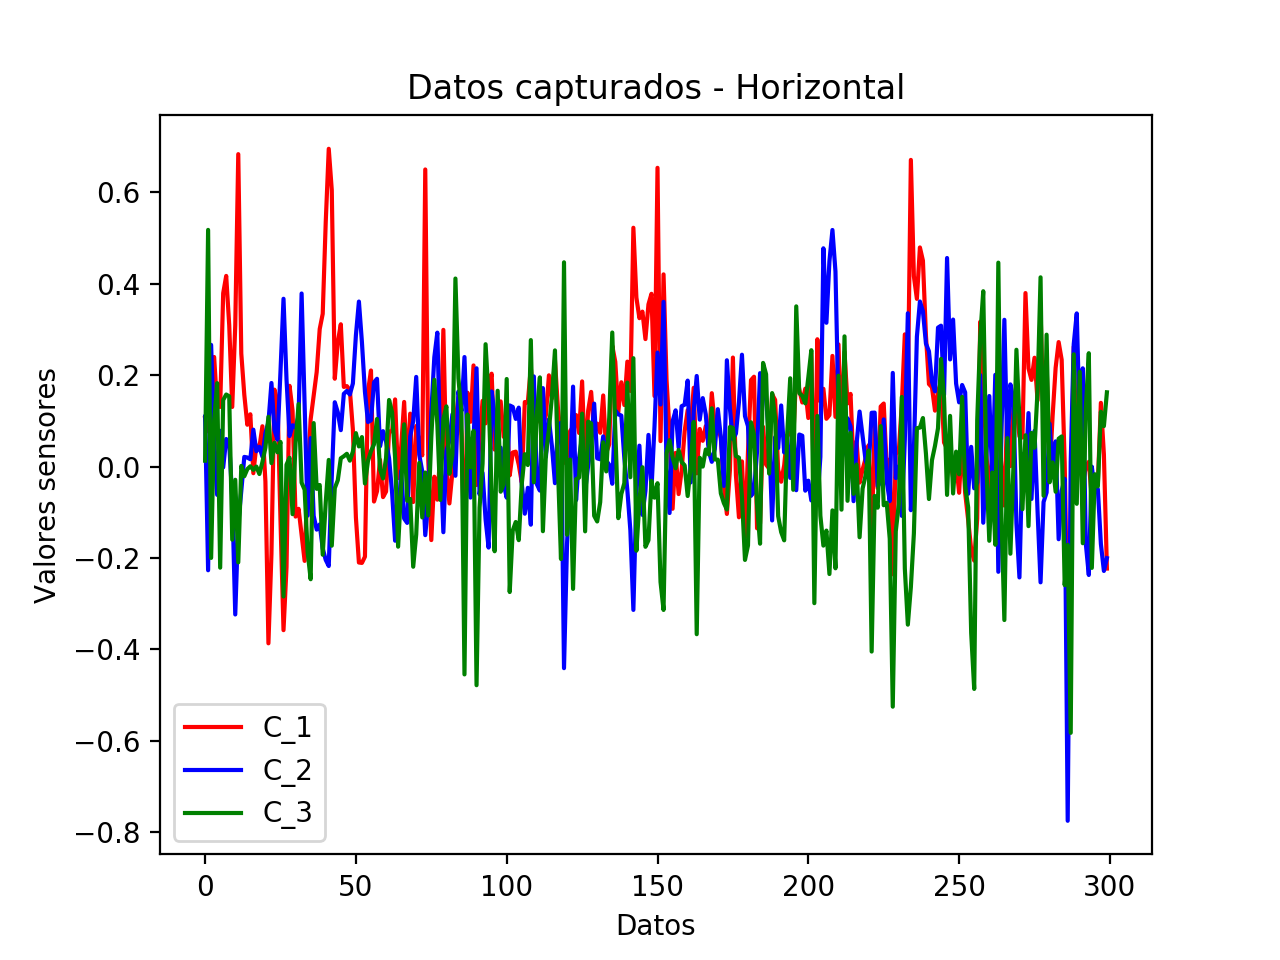

In [22]:
dibujar_sensores_pca(principalComponentsTotal3[4000:4300])#dibujar_sensores(x[4000:4300])

## 5. Transformacion de los datos

Generacion de secuencias de 2 a 5 pasos

In [23]:
def generate_seq_data1(d, l):
    inp = []
    for i in range(len(d)):
        if len(d)>i+l-1:
            inp.append(d[i:i+l])
    return np.asarray(inp)

In [24]:
i_e3 = generate_seq_data1(principalComponents3, 3)

In [25]:
test_3 = generate_seq_data1(principalComponentsTest, 3)

In [26]:
total_3 = generate_seq_data1(principalComponentsTotal3, 3)

In [27]:
#import tensorflow as tf
import random as rn

rand_seed = 321

np.random.seed(rand_seed)
tf.set_random_seed(rand_seed)
lrelu = lambda x:tf.keras.activations.relu(x, alpha=0.1)

## 6. Division del conjunto de datos

Division del conjunto de datos, en conjunto de entrenamiento, desarrollo y prueba

In [28]:
np.random.shuffle(i_e3)

train3, dev3, test3 = np.split(i_e3, [int(.70*len(i_e3)), int(.85*len(i_e3))])

## 7. Modelo de comportamiento normal

Generar el modelo Autoencoder

In [29]:
inputs = Input(shape=(3,3))
x = Flatten()(inputs) #49152 #3072
#x = BatchNormalization()(x)
x = Dense(8, activation='elu')(x)
encoded = Dense(5, activation='elu')(x)
encoder = Model(inputs, encoded)
encoder.summary()

decoder_input= Input(shape=(5,))
#x = BatchNormalization()(x)
x = Dense(8, activation='elu')(decoder_input)
outputs = Dense(9, activation='tanh')(x)
#outputs = BatchNormalization()(outputs)
decoded = Reshape((3,3))(outputs)

decoder = Model(decoder_input, decoded)
decoder.summary()

auto_input = Input(shape=(3,3))
encoded = encoder(auto_input)
decoded = decoder(encoded)

model_nn3 = Model(auto_input, decoded)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 3)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 80        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 45        
Total params: 125
Trainable params: 125
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_3 (Den

In [30]:
model_nn3.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = model_nn3.fit(train3, train3,
                epochs=50,
                batch_size=64,
                validation_data=(dev3, dev3),
                verbose=1)

Train on 20998 samples, validate on 4500 samples
Epoch 1/50
20998/20998 [==============================] - 1s 25us/step - loss: 0.0187 - acc: 0.6493 - val_loss: 0.0081 - val_acc: 0.8390
Epoch 2/50
20998/20998 [==============================] - 0s 20us/step - loss: 0.0065 - acc: 0.8610 - val_loss: 0.0055 - val_acc: 0.8724
Epoch 3/50
20998/20998 [==============================] - 0s 19us/step - loss: 0.0052 - acc: 0.8770 - val_loss: 0.0049 - val_acc: 0.8793
Epoch 4/50
20998/20998 [==============================] - 0s 19us/step - loss: 0.0047 - acc: 0.8837 - val_loss: 0.0046 - val_acc: 0.8875
Epoch 5/50
20998/20998 [==============================] - 0s 21us/step - loss: 0.0045 - acc: 0.8899 - val_loss: 0.0044 - val_acc: 0.8926
Epoch 6/50
20998/20998 [==============================] - 0s 20us/step - loss: 0.0043 - acc: 0.8939 - val_loss: 0.0043 - val_acc: 0.8950
Epoch 7/50
20998/20998 [==============================] - 0s 19us/step - loss: 0.0042 - acc: 0.8967 - val_loss: 0.0042 - val_acc:

In [31]:
model_nn3.evaluate(test3, test3, verbose=1)

4500/4500 [==============================] - 0s 18us/step


[0.003956934413148297, 0.9000740711953905]

## 8. Metodo de deteccion de anomalias

Generacion del modelo con bosques de aislamiento (Isolation Forest)

In [32]:
def isolationForestModel(diff, cont= 0.1):
    model =  IsolationForest(contamination=cont)
    model.fit(diff)
    return model

In [33]:
# result_nn3 = model_nn3.predict(i_e_total3)
result_nn3 = model_nn3.predict(i_e3)

# diff_nn3 = result_nn3 - i_e_total3
diff_nn3 = result_nn3 - i_e3

In [34]:
#isolation_model = isolationForestModel(predicted.reshape(len(predicted), 5), 0.0075)
isolation_model = isolationForestModel(diff_nn3.reshape(len(diff_nn3), 9), 0.00750)

In [35]:
i_e_total3 = generate_seq_data1(principalComponentsTotal3, 3)

In [36]:
result_nn3 = model_nn3.predict(test_3)
#result_nn3 = model_nn3.predict(i_e3)

diff_nn3 = result_nn3 - test_3
#diff_nn3 = result_nn3 - i_e3

# mse_nn3 = np.power(np.absolute(diff_nn3), 2).sum(axis=1).sum(axis=1)
mse_nn3 =  np.power(np.absolute(diff_nn3).sum(axis=1).sum(axis=1),2)

In [37]:
#error_df = pd.DataFrame({'anomaly': isolation_model.predict(predicted.reshape(len(predicted), 5)),
#                        'true_class': datos_total['anomaly'].as_matrix()[2:-20]})
error_df = pd.DataFrame({'anomaly': isolation_model.predict(diff_nn3.reshape(len(diff_nn3), 9)),
                        'true_class': data_test['anomaly'].as_matrix()[2:-20]})

/Users/bender/opt/miniconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [38]:
error_df['anomaly1'] = error_df['anomaly'].replace({1:0, -1:1})

## 9. Evaluacion del mecanismo de deteccion de anomalias

In [39]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import seaborn as sns

<IPython.core.display.Javascript object>


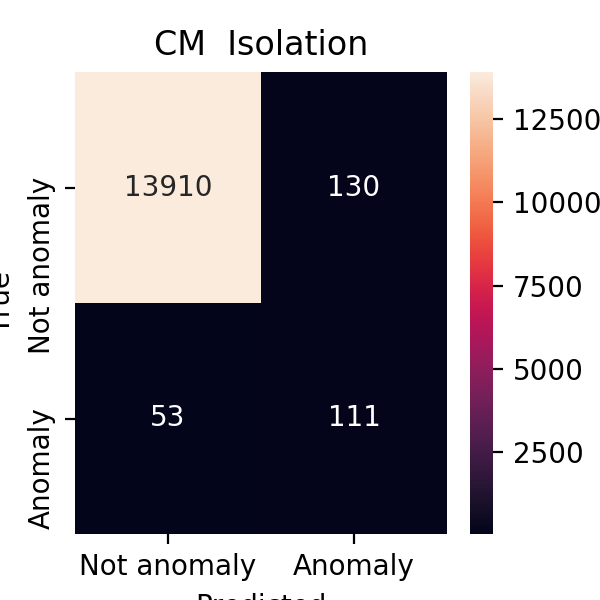

In [40]:
conf_matrix = confusion_matrix(error_df.true_class, error_df.anomaly1)
lbl_class = ["Not anomaly", "Anomaly"]

plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, xticklabels=lbl_class, yticklabels=lbl_class, annot=True, fmt="d");
plt.title("CM " + " Isolation")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [41]:
import matplotlib.transforms as mtransforms

def dibujar_anomalias1(df, nombre, anomalias):
    fig, ax = plt.subplots()
    indices = list(range(0,len(df)))
    
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

    ax.plot(indices, df[:,0], 'r', label='ACC-X')
    ax.plot(indices, df[:,1], 'b', label='ACC-Y')
    ax.plot(indices, df[:,2], 'g', label='ACC-Z')
    
    ax.plot(indices, df[:,3], 'm', label='GYR-X')
    ax.plot(indices, df[:,4], 'c', label='GYR-Y')
    ax.plot(indices, df[:,5], 'k', label='GYR-Z')
    
    ax.fill_between(indices, 0, 1, where=error_df['true_class'].as_matrix() > 0.5,  facecolor='yellow', alpha=0.45, transform=trans)

    ax.fill_between(indices, 0, 1, where=anomalias > 0.5, facecolor='red', alpha=0.45, transform=trans)

    ax.set(ylabel='Valores sensores', xlabel='Tiempo (Segundos)', title=nombre)
    ax.legend()
    plt.grid()
    plt.show() 

In [1]:
#dibujar_anomalias1(datos_total[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].as_matrix()[2:-20].reshape(len(datos_total)-22, 6), 'Visualizacion de anomalias detectadas',error_df.anomaly1)

## 10. Guardar modelos

In [42]:
import json # will be needed for saving preprocessing details
import joblib # for saving algorithm and preprocessing objects
from multiprocessing import Queue

In [43]:
# save preprocessing objects and RF algorithm
joblib.dump(scaler, "./scaler.joblib", compress=True)
joblib.dump(pca3, "./pca.joblib", compress=True)
joblib.dump(isolation_model, "./isolation_model.joblib", compress=True)
#joblib.dump(model_nn3, "./model_nn3.joblib", compress=True)

['./isolation_model.joblib']

In [45]:
#from tensorflow import keras
from keras.models import load_model
# Guardar el Modelo
model_nn3.save('model_nn3.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
new_model = load_model('model_nn3.h5')

## 11. Evaluacion del mecanismo de deteccion de anomalias por tipo de anomalia

In [46]:
# Anomalias
type_anomaly = np.zeros(len(datos_total))

type_anomaly[22865:22892]=2 # zig zag
type_anomaly[22903:22926]= 0 # tierra
type_anomaly[22966:22990]=2 # zig zag
type_anomaly[23015:23027]=2 # zig zag
type_anomaly[23158:23183]= 0 # tierra
type_anomaly[23212:23236]=2 # zig zag 
type_anomaly[23256:23274]=2 # zig zag

type_anomaly[23556:23562]=3 # giros a alta velocidad
type_anomaly[23590:23596]=3
type_anomaly[23606:23612]=3
type_anomaly[23615:23621]=3
type_anomaly[23760:23766]=3
type_anomaly[23774:23779]=3
type_anomaly[24794:24798]=3

type_anomaly[23933:24939]=0 # anomalias raras
type_anomaly[25076:25086]=0

type_anomaly[25502:25506]=4 # frenos en seco
type_anomaly[25575:25579]=4
type_anomaly[25623:25627]=4
type_anomaly[25710:25714]=4
type_anomaly[25838:25842]=4
type_anomaly[25871:25875]=4

datos_total['type_anomaly'] = type_anomaly

In [47]:
result_nn3 = model_nn3.predict(i_e_total3)
#result_nn3 = model_nn3.predict(i_e3)

diff_nn3 = result_nn3 - i_e_total3
#diff_nn3 = result_nn3 - i_e3

result = isolation_model.predict(diff_nn3.reshape(len(diff_nn3), 9))

In [48]:
print(len(result))
print(len(datos_total['type_anomaly'].as_matrix()[2:-20]))

44204
44204


/Users/bender/opt/miniconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [49]:
# ZigZag
t_a = datos_total['type_anomaly'].as_matrix()[2:-20]
new = pd.DataFrame({'type_anomaly': t_a})
new['resultado'] = np.array(result)
new.loc[(new['resultado'] == -1) & (new['type_anomaly'] == 2), 'tipo'] = 'True' 
new.loc[new['resultado'] == 1, 'tipo'] = 'False'
new['tipo'].value_counts()

/Users/bender/opt/miniconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


False    43746
True        69
Name: tipo, dtype: int64

In [50]:
# Giros
t_a = datos_total['type_anomaly'].as_matrix()[2:-20]
new = pd.DataFrame({'type_anomaly': t_a})
new['resultado'] = np.array(result)
new.loc[(new['resultado'] == -1) & (new['type_anomaly'] == 3), 'tipo'] = 'True' 
new.loc[new['resultado'] == 1, 'tipo'] = 'False'
new['tipo'].value_counts()

/Users/bender/opt/miniconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


False    43746
True        23
Name: tipo, dtype: int64

In [51]:
# Frenos
t_a = datos_total['type_anomaly'].as_matrix()[2:-20]
new = pd.DataFrame({'type_anomaly': t_a})
new['resultado'] = np.array(result)
new.loc[(new['resultado'] == -1) & (new['type_anomaly'] == 4), 'tipo'] = 'True' 
new.loc[new['resultado'] == 1, 'tipo'] = 'False'
new['tipo'].value_counts()

/Users/bender/opt/miniconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


False    43746
True        19
Name: tipo, dtype: int64

In [52]:
new['type_anomaly'].value_counts()

0.0    44040
2.0      105
3.0       35
4.0       24
Name: type_anomaly, dtype: int64